In [1]:
# from datasets import load_dataset
# ds = load_dataset("nlphuji/flickr30k")
# print(ds['test'][0])  # Contains "image" (PIL object) and "caption"

In [2]:
from datasets import load_dataset

ds = load_dataset("arampacha/rsicd")

{'filename': 'rsicd_images/airport_1.jpg', 'captions': ['Many aircraft are parked next to a long building in an airport.', 'Many planes are parked next to a long building at an airport.', 'Many planes are parked next to a long building in an airport.', 'many planes are parked next to a long building at an airport.', 'many planes are parked next to a long building in an airport .'], 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x16B5BB3D0>}


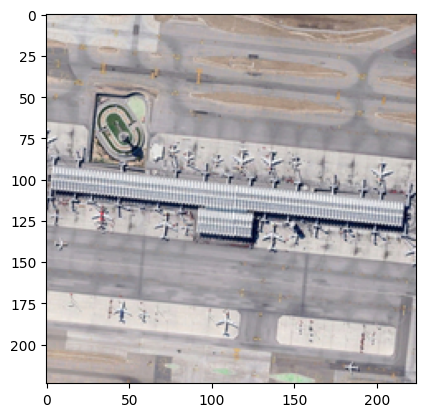

In [3]:
# sample
print(ds['train'][0])  # Contains "image" (PIL object) and "caption"
# display image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img = ds['train'][0]['image']
plt.imshow(np.array(img))


In [4]:
# get dataset name
ds['train'].info.dataset_name

'rsicd'

{'filename': 'rsicd_images/airport_1.jpg', 'captions': ['Many aircraft are parked next to a long building in an airport.', 'Many planes are parked next to a long building at an airport.', 'Many planes are parked next to a long building in an airport.', 'many planes are parked next to a long building at an airport.', 'many planes are parked next to a long building in an airport .'], 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x31F1EF410>}
['Many aircraft are parked next to a long building in an airport.', 'Many planes are parked next to a long building at an airport.', 'Many planes are parked next to a long building in an airport.', 'many planes are parked next to a long building at an airport.', 'many planes are parked next to a long building in an airport .']


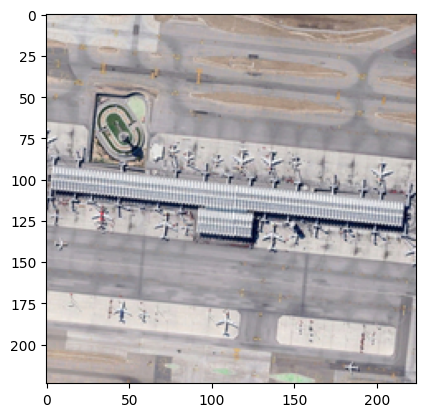

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import CLIPProcessor, CLIPModel, GPT2Tokenizer, GPT2LMHeadModel
from datasets import load_dataset
from PIL import Image
import requests
import io
import os

# Load RSICD dataset
dataset = load_dataset("arampacha/rsicd", split="train")

print(dataset[0])  # Contains "image" (PIL object) and "caption"

item = dataset[0]
img = item['image']
plt.imshow(np.array(img))
captions = item["captions"]
print (captions)

In [6]:
# Load CLIP and GPT-2 models
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token


image_url = item["image"]  # RSICD dataset contains direct image URLs
captions = item["captions"]

# Load and process image
# response = requests.get(image_url)
# image = Image.open(io.BytesIO(response.content)).convert("RGB")


print (image_url)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x31F275490>


In [7]:




# # Define the mapping network
# class MappingNetwork(nn.Module):
#     def __init__(self, clip_embedding_dim, prefix_length, gpt2_embedding_dim):
#         super(MappingNetwork, self).__init__()
#         self.prefix_length = prefix_length
#         self.gpt2_embedding_dim = gpt2_embedding_dim
#         self.fc = nn.Sequential(
#             nn.Linear(clip_embedding_dim, (clip_embedding_dim + prefix_length * gpt2_embedding_dim) // 2),
#             nn.ReLU(),
#             nn.Linear((clip_embedding_dim + prefix_length * gpt2_embedding_dim) // 2, prefix_length * gpt2_embedding_dim)
#         )

#     def forward(self, clip_embedding):
#         mapped = self.fc(clip_embedding)  # (batch_size, prefix_length * gpt2_embedding_dim)
#         mapped = mapped.view(-1, self.prefix_length, self.gpt2_embedding_dim)  # Reshape for GPT-2
#         return mapped

# # Custom dataset class for training
# class SatelliteImageCaptionDataset(torch.utils.data.Dataset):
#     def __init__(self, dataset, clip_processor, tokenizer, prefix_length):
#         self.data = dataset
#         self.clip_processor = clip_processor
#         self.tokenizer = tokenizer
#         self.prefix_length = prefix_length

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         item = self.data[idx]
#         # image_url = item["image"]
#         image = item["image"]
#         captions = item["captions"]

#         # Load and process image
#         # response = requests.get(image_url)
#         # image = Image.open(io.BytesIO(response.content)).convert("RGB")
#         # clip_inputs = self.clip_processor(images=image, return_tensors="pt")
#         # clip_embedding = clip_model.get_image_features(**clip_inputs).squeeze(0)  # Shape: (512,)
#         clip_inputs = self.clip_processor(images=image, return_tensors="pt")
#         clip_embedding = clip_model.get_image_features(**clip_inputs).squeeze(0)

#         # Tokenize caption
#         tokens = self.tokenizer(captions[0], return_tensors="pt", padding="max_length", truncation=True, max_length=50)
#         input_ids = tokens["input_ids"].squeeze(0)  # Shape: (max_length,)

#         return clip_embedding, input_ids

# # Initialize dataset and dataloader
# train_dataset = SatelliteImageCaptionDataset(dataset, clip_processor, gpt2_tokenizer, prefix_length=10)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

# # Initialize mapping network and optimizer
# mapping_network = MappingNetwork(clip_embedding_dim=512, prefix_length=10, gpt2_embedding_dim=768).to(device)
# optimizer = optim.Adam(mapping_network.parameters(), lr=1e-4)
# criterion = nn.CrossEntropyLoss()

# # Training loop
# epochs = 5
# for epoch in range(epochs):
#     for clip_embeddings, captions in train_dataloader:
#         clip_embeddings, captions = clip_embeddings.to(device), captions.to(device)

#         # Generate GPT-2 prefixes
#         prefixes = mapping_network(clip_embeddings)  # (batch_size, prefix_length, gpt2_embedding_dim)

#         # Convert captions to GPT-2 embeddings
#         gpt2_inputs_embeds = gpt2_model.transformer.wte(captions[:, :-1])  # Remove last token for teacher forcing

#         # Concatenate prefix and caption embeddings
#         inputs_embeds = torch.cat((prefixes, gpt2_inputs_embeds), dim=1)

#         # Forward pass through GPT-2
#         outputs = gpt2_model(inputs_embeds=inputs_embeds, labels=captions)

#         # Compute loss
#         loss = outputs.loss
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

# # Save the trained mapping network
# save_path = "mapping_network.pth"
# if not os.path.exists(save_path):
#     torch.save(mapping_network.state_dict(), save_path)
# else:
#     print(f"File {save_path} already exists. Skipping save.")
# print("Training complete!")


In [ ]:
dataset = load_dataset("arampacha/rsicd") #, split="train")

dataset['train'][0]

{'filename': 'rsicd_images/airport_1.jpg',
 'captions': ['Many aircraft are parked next to a long building in an airport.',
  'Many planes are parked next to a long building at an airport.',
  'Many planes are parked next to a long building in an airport.',
  'many planes are parked next to a long building at an airport.',
  'many planes are parked next to a long building in an airport .'],
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>}

: 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as func
from transformers import CLIPProcessor, CLIPModel, GPT2Tokenizer, GPT2LMHeadModel
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

# Load RSICD dataset
dataset = load_dataset("arampacha/rsicd", split="train")

# Load CLIP and GPT-2 models
device = torch.device("mps")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# Define the mapping network
class MappingNetwork(nn.Module):
    def __init__(self, clip_embedding_dim, prefix_length, gpt2_embedding_dim):
        super(MappingNetwork, self).__init__()
        self.prefix_length = prefix_length
        self.gpt2_embedding_dim = gpt2_embedding_dim
        self.fc = nn.Sequential(
            nn.Linear(clip_embedding_dim, (clip_embedding_dim + prefix_length * gpt2_embedding_dim) // 2),
            nn.ReLU(),
            nn.Linear((clip_embedding_dim + prefix_length * gpt2_embedding_dim) // 2, prefix_length * gpt2_embedding_dim)
        )

    def forward(self, clip_embedding):
        mapped = self.fc(clip_embedding)  # (batch_size, prefix_length * gpt2_embedding_dim)
        mapped = mapped.view(-1, self.prefix_length, self.gpt2_embedding_dim)  # Reshape for GPT-2
        return mapped

class MappingNetwork2(nn.Module):
    def __init__(self, clip_embedding_dim, prefix_length, gpt2_embedding_dim):
        super(MappingNetwork2, self).__init__()
        self.prefix_length = prefix_length
        self.gpt2_embedding_dim = gpt2_embedding_dim
        self.fc = nn.Sequential(
            nn.Linear(clip_embedding_dim, (clip_embedding_dim + prefix_length * gpt2_embedding_dim) // 2),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear((clip_embedding_dim + prefix_length * gpt2_embedding_dim) // 2, prefix_length * gpt2_embedding_dim),
            nn.Dropout(0.1),
        )

    def forward(self, clip_embedding):
        mapped = self.fc(clip_embedding)  # (batch_size, prefix_length * gpt2_embedding_dim)
        mapped = mapped.view(-1, self.prefix_length, self.gpt2_embedding_dim)  # Reshape for GPT-2
        return mapped


# Custom dataset class for training
class SatelliteImageCaptionDataset(Dataset):
    def __init__(self, dataset, clip_processor, tokenizer, prefix_length):
        self.data = dataset
        self.clip_processor = clip_processor
        self.tokenizer = tokenizer
        self.prefix_length = prefix_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item["image"]  # Direct PIL image
        caption = item["captions"][0]  # First caption

        # Convert image to CLIP features
        clip_inputs = self.clip_processor(images=image, return_tensors="pt").to(device)
        clip_embedding = clip_model.get_image_features(**clip_inputs).squeeze(0) #.to(device)  # Shape: (512,)

        # Tokenize caption
        tokens = self.tokenizer(caption, return_tensors="pt", padding="max_length", truncation=True, max_length=50)
        input_ids = tokens["input_ids"].squeeze(0)  # Shape: (max_length,)

        return clip_embedding, input_ids

# Initialize dataset and dataloader
train_dataset = SatelliteImageCaptionDataset(dataset, clip_processor, gpt2_tokenizer, prefix_length=10)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Initialize mapping network and optimizer
mapping_network = MappingNetwork2(clip_embedding_dim=512, prefix_length=10, gpt2_embedding_dim=768).to(device)
optimizer = optim.Adam(mapping_network.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 10
for epoch in range(epochs):
    progress = tqdm(total=len(train_dataloader))
    for clip_embeddings, captions in train_dataloader:
        clip_embeddings, captions = clip_embeddings.to(device), captions.to(device)
        # Generate GPT-2 prefixes (batch_size, prefix_length, gpt2_embedding_dim)
        prefixes = mapping_network(clip_embeddings)  

        # Get actual sequence length of each caption
        caption_lengths = (captions != gpt2_tokenizer.pad_token_id).sum(dim=1)

        # Ensure all captions are at least prefix_length long
        max_caption_length = captions.shape[1]
        total_length = min(max_caption_length + prefixes.shape[1], 50)  # GPT-2 max input size

        # Prepare input tensors with correct size
        gpt2_inputs = torch.cat([torch.zeros(captions.shape[0], prefixes.shape[1], dtype=torch.long, device=device), captions], dim=1)  # (batch_size, prefix_length + caption_length)
        gpt2_inputs = gpt2_inputs[:, :total_length]  # Ensure consistency in sequence length

        # Convert to GPT-2 embeddings
        gpt2_inputs_embeds = gpt2_model.transformer.wte(gpt2_inputs)  # (batch_size, total_length, gpt2_embedding_dim)

        # Forward pass through GPT-2
        outputs = gpt2_model(inputs_embeds=gpt2_inputs_embeds, labels=gpt2_inputs)

        # Compute loss
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress.set_postfix({"loss": loss.item()})
        progress.update()

    progress.close()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

# Save the trained mapping network
torch.save(mapping_network.state_dict(), "mapping_network2.pth")
print("Training complete!")


100%|██████████| 1092/1092 [15:57<00:00,  1.14it/s, loss=9.48]   


Epoch [1/10], Loss: 9.483839988708496


100%|██████████| 1092/1092 [05:16<00:00,  3.45it/s, loss=8.88]


Epoch [2/10], Loss: 8.87873363494873


100%|██████████| 1092/1092 [47:50<00:00,  2.63s/it, loss=9.09]   


Epoch [3/10], Loss: 9.086441993713379


100%|██████████| 1092/1092 [05:22<00:00,  3.39it/s, loss=9]   


Epoch [4/10], Loss: 8.996905326843262


100%|██████████| 1092/1092 [05:15<00:00,  3.46it/s, loss=9.81]


Epoch [5/10], Loss: 9.80631160736084


100%|██████████| 1092/1092 [09:05<00:00,  2.00it/s, loss=9.34]  


Epoch [6/10], Loss: 9.34261703491211


100%|██████████| 1092/1092 [05:15<00:00,  3.46it/s, loss=9.78]


Epoch [7/10], Loss: 9.778851509094238


100%|██████████| 1092/1092 [26:12<00:00,  1.44s/it, loss=9.07]   


Epoch [8/10], Loss: 9.065808296203613


100%|██████████| 1092/1092 [05:19<00:00,  3.42it/s, loss=9.42]


Epoch [9/10], Loss: 9.415937423706055


100%|██████████| 1092/1092 [05:24<00:00,  3.36it/s, loss=9.22]


Epoch [10/10], Loss: 9.219523429870605
Training complete!
